In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split

In [29]:
dic = pickle.load(open('trainingDataSetSmallHSC_RC2.pkl', 'rb'))
data=pd.DataFrame(dic)

StarID=np.array(data.columns)
star= np.array(data.iloc[0])

dicc= dict(zip(StarID, star))

In [30]:
#Tener en cuenta que las imágenes ya están normalizadas
all_images= np.array(data.iloc[0])
# Convierte a un array NumPy 3D: (N, 25, 25)
all_images = np.stack(all_images)  
# Agrega canal para PyTorch: (N, 1, 25, 25)
all_images = np.expand_dims(all_images, axis=1)

In [31]:
piff = np.array(data.iloc[2])
piff=np.stack(piff)
piff=np.expand_dims(piff,axis=1)

In [32]:
# Convierte los arreglos a tensores con tipo float32 para compatibilidad con PyTorch
tensor_images = torch.tensor(all_images, dtype=torch.float32)

# Dataset completo (usamos las imágenes como entrada y como objetivo)
dataset = TensorDataset(tensor_images, tensor_images)

# Define proporciones para entrenamiento y validación
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación

# Fijar la semilla
generator = torch.Generator().manual_seed(1)

# Divide el dataset aleatoriamente
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Crea DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffle=True mezcla aleatoriamente los datos 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(all_images.min(), all_images.max())

-0.024684794 0.5590923


In [33]:
class PAE(nn.Module):
    def __init__(self, latent_dim: int, regularize: bool = False):
        super().__init__()
        self.regularize = regularize

        # Encoder: 625 → 256
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(625, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder: latent → 625
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 625),
            nn.Softmax(dim=1),
            nn.Unflatten(1, (1, 25, 25))
        )

    def encode(self, x):
        h = self.encoder_fc(x)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        x_recon = x_recon / x_recon.sum(dim=(2,3), keepdim=True)
        return x_recon, mu, log_var, z


def pae_loss(reconstructed, target, mu=None, log_var=None, reg_weight=1e-4):
    recon_loss = nn.MSELoss()(reconstructed, target)

    if mu is not None and log_var is not None:
        # Regularización suave del espacio latente (sin KL)
        reg_loss = torch.mean(mu**2 + torch.exp(log_var) - log_var - 1)
        return recon_loss + reg_weight * reg_loss
    else:
        return recon_loss



In [34]:
# Dimensión del espacio latente
latent_dim = 2

# Dispositivo
device = torch.device("cpu")

# Modelo
pae = PAE(latent_dim=latent_dim).to(device)

# Optimizador
optimizer = torch.optim.Adam(pae.parameters(), lr=1e-5)

# Número de épocas
num_epochs = 50

train_loss_per_epoch = []
val_loss_per_epoch = []

# Entrenamiento
for epoch in range(num_epochs):
    pae.train()
    total_train_loss = 0

    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar, _ = pae(x_batch)  # Desempacar los outputs
        loss = pae_loss(x_hat, x_batch, mu, logvar)  # Pasar mu y logvar a la loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_per_epoch.append(avg_train_loss)

    # Evaluación
    pae.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(device)
            x_hat_val, mu_val, logvar_val, _ = pae(x_val)
            val_loss = pae_loss(x_hat_val, x_val, mu_val, logvar_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_per_epoch.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.10f}, Val Loss: {avg_val_loss:.10f}")





Epoch 1, Train Loss: 0.0000429016, Val Loss: 0.0000412150
Epoch 2, Train Loss: 0.0000291716, Val Loss: 0.0000157933
Epoch 3, Train Loss: 0.0000123645, Val Loss: 0.0000104423
Epoch 4, Train Loss: 0.0000102029, Val Loss: 0.0000096989
Epoch 5, Train Loss: 0.0000094442, Val Loss: 0.0000092130
Epoch 6, Train Loss: 0.0000091572, Val Loss: 0.0000089417
Epoch 7, Train Loss: 0.0000089203, Val Loss: 0.0000088330
Epoch 8, Train Loss: 0.0000088001, Val Loss: 0.0000087360
Epoch 9, Train Loss: 0.0000087187, Val Loss: 0.0000086550
Epoch 10, Train Loss: 0.0000086359, Val Loss: 0.0000085823
Epoch 11, Train Loss: 0.0000086160, Val Loss: 0.0000085455
Epoch 12, Train Loss: 0.0000085888, Val Loss: 0.0000085149
Epoch 13, Train Loss: 0.0000085630, Val Loss: 0.0000085106
Epoch 14, Train Loss: 0.0000085440, Val Loss: 0.0000084704
Epoch 15, Train Loss: 0.0000085213, Val Loss: 0.0000084444
Epoch 16, Train Loss: 0.0000085018, Val Loss: 0.0000084556
Epoch 17, Train Loss: 0.0000085003, Val Loss: 0.0000084544
Epoch 

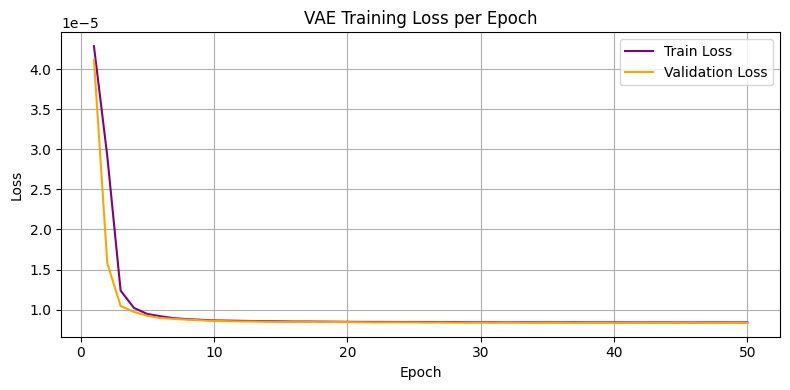

In [35]:
# Graficar pérdida por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch, label="Train Loss", color='purple')
plt.plot(range(1, len(val_loss_per_epoch) + 1), val_loss_per_epoch, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

MSE entre entradas y reconstrucciones: 0.000006217318969


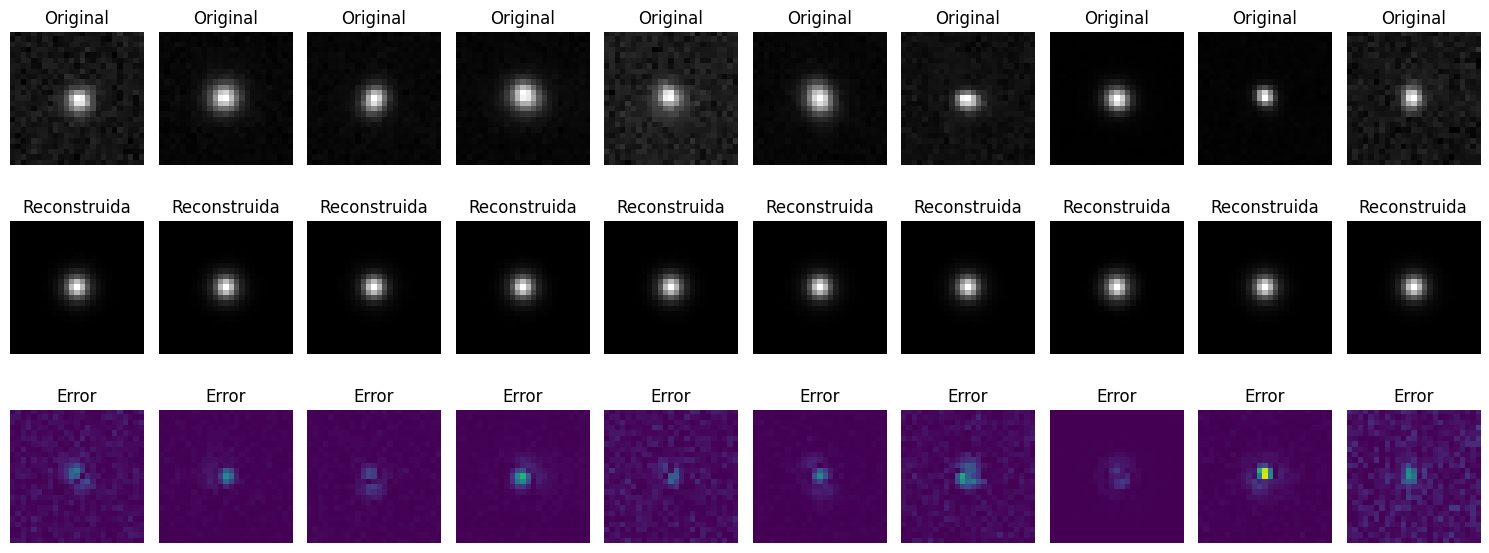

In [36]:
# Ponemos el PAE en modo evaluación
pae.eval()

# Tomamos un batch del conjunto de validación
x_val_batch, _ = next(iter(val_loader))
x_val_batch = x_val_batch.to(device)

with torch.no_grad():
    # Pasamos las imágenes por el PAE y tomamos solo x_hat
    x_hat, _, _, _ = pae(x_val_batch)

# Calculamos el error absoluto
errors = torch.abs(x_val_batch - x_hat)

# Calculamos el error cuadrático medio (MSE)
MSE = nn.MSELoss()(x_hat, x_val_batch).item()
print(f"MSE entre entradas y reconstrucciones: {MSE:.15f}")

# Visualizamos imágenes originales, reconstruidas y su error
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(15, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_batch[i, 0].cpu(), cmap="gray")
    ax.set_title("Original")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_hat[i, 0].cpu(), cmap="gray")
    ax.set_title("Reconstruida")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(errors[i, 0].cpu(), cmap="viridis", vmax=0.05)
    ax.set_title("Error")
    plt.axis("off")

plt.tight_layout()
plt.show()




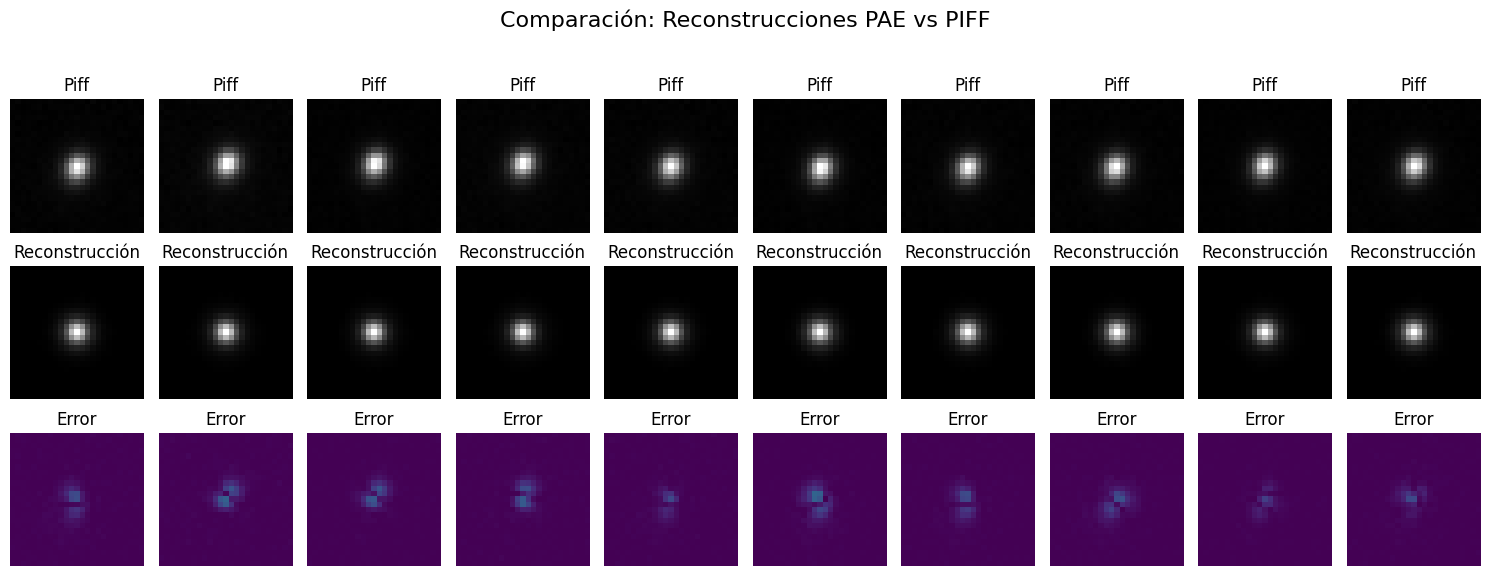

MSE entre reconstrucciones (PAE) y PIFF: 0.000005819747457


In [37]:
# Poner el PAE en modo evaluación
pae.eval()

# Loaders sin shuffle para mantener el orden
train_loader = DataLoader(all_images, batch_size=32, shuffle=False) 
piff_loader  = DataLoader(piff, batch_size=32, shuffle=False)

all_errors = []
all_inputs = []
all_reconstructions = []
all_piffs = []

with torch.no_grad():
    for x_val_batch, x_piff_batch in zip(train_loader, piff_loader):
        x_val_batch = x_val_batch.to(device)
        x_piff_batch = x_piff_batch.to(device)

        # Reconstrucción con PAE (extraemos solo x_hat)
        x_hat, _, _, _ = pae(x_val_batch)

        # Guardar datos
        errors = torch.abs(x_piff_batch - x_hat)
        all_errors.append(errors.cpu())
        all_inputs.append(x_val_batch.cpu())
        all_reconstructions.append(x_hat.cpu())
        all_piffs.append(x_piff_batch.cpu())

# Concatenar todos los batches
all_errors = torch.cat(all_errors)
all_inputs = torch.cat(all_inputs)
all_reconstructions = torch.cat(all_reconstructions)
all_piffs = torch.cat(all_piffs)

# Mostrar las primeras N imágenes
n = 10
plt.figure(figsize=(15, 6))

for i in range(n):
    # Imagen PIFF (referencia)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(all_piffs[i, 0], cmap="gray")
    ax.set_title("Piff")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(all_reconstructions[i, 0], cmap="gray")
    ax.set_title("Reconstrucción")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(all_errors[i, 0], cmap="viridis", vmax=0.05)
    ax.set_title("Error")
    plt.axis("off")

# Título general de la figura
plt.suptitle("Comparación: Reconstrucciones PAE vs PIFF", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Calcular el MSE total entre reconstrucciones y piff
MSE = nn.MSELoss()(all_reconstructions, all_piffs).item()
print(f"MSE entre reconstrucciones (PAE) y PIFF: {MSE:.15f}")

